            gene       sec1       sec2       sec3       sec4       sec5  \
0         Hivep3     0.1698   0.163654   0.150759   0.127239   0.137511   
1         Mif4gd   40.48777  46.075047  54.927906   52.73647  48.692463   
2        Slitrk2   0.473337   0.543727   0.483445   0.460375    0.41672   
3           Lnx1  24.436026  20.430279  20.012865  21.477146  22.131317   
4  2610002J23Rik  28.416124  26.881475   27.86931  30.550655   30.50585   

        sec6       sec7       sec8       sec9  ...      sec52      sec53  \
0   0.158237    0.10217    0.17124   0.259784  ...    0.16483    0.13215   
1  45.125027  51.563934  44.451153  36.604103  ...  49.896103  50.075268   
2   0.348434   0.407794   0.506502   0.436232  ...   0.549582   0.589768   
3   22.68282  19.848505  19.808392   24.10315  ...  28.345238  29.063787   
4  30.338135   28.21356   29.29947  30.789057  ...  32.600925   33.16024   

       sec54      sec55      sec56      sec57      sec58      sec59  \
0   0.124009   0.2901

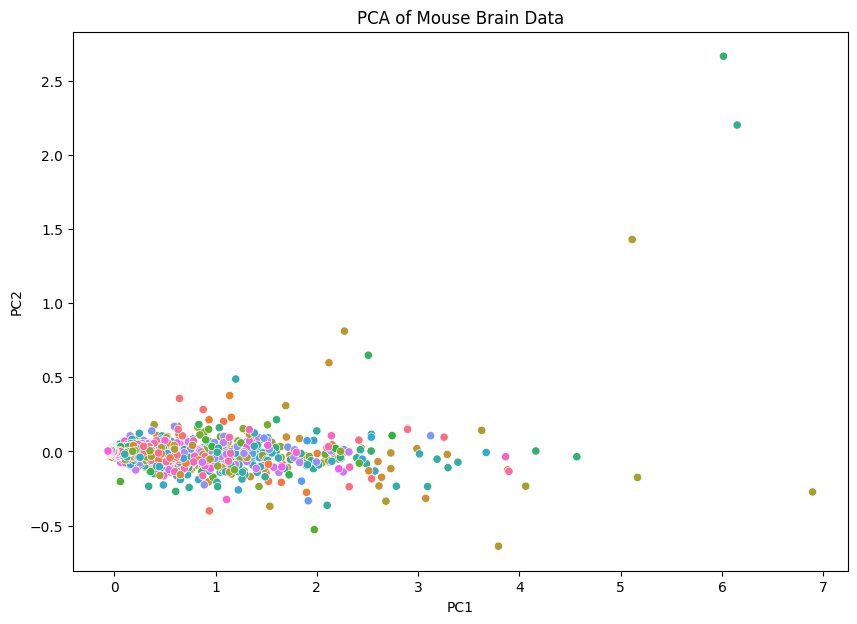

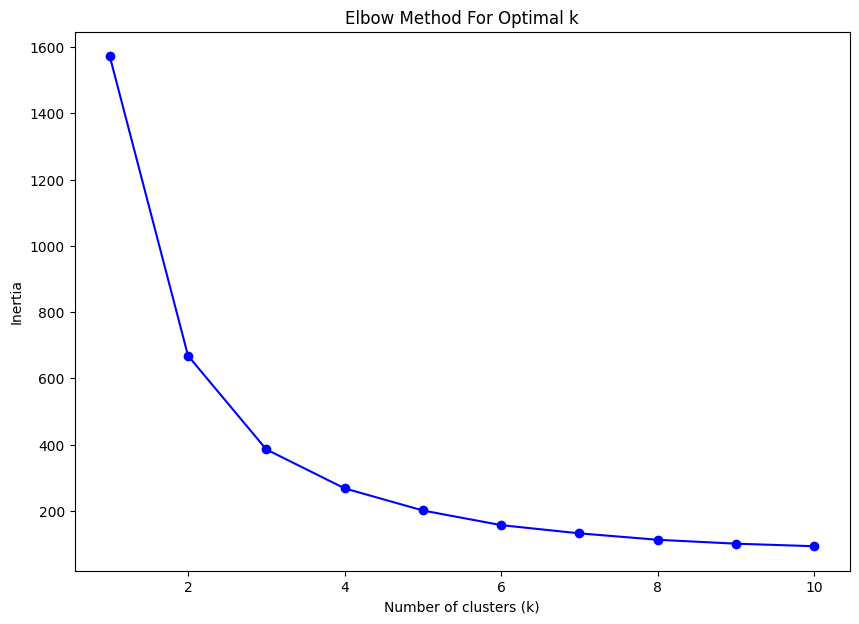

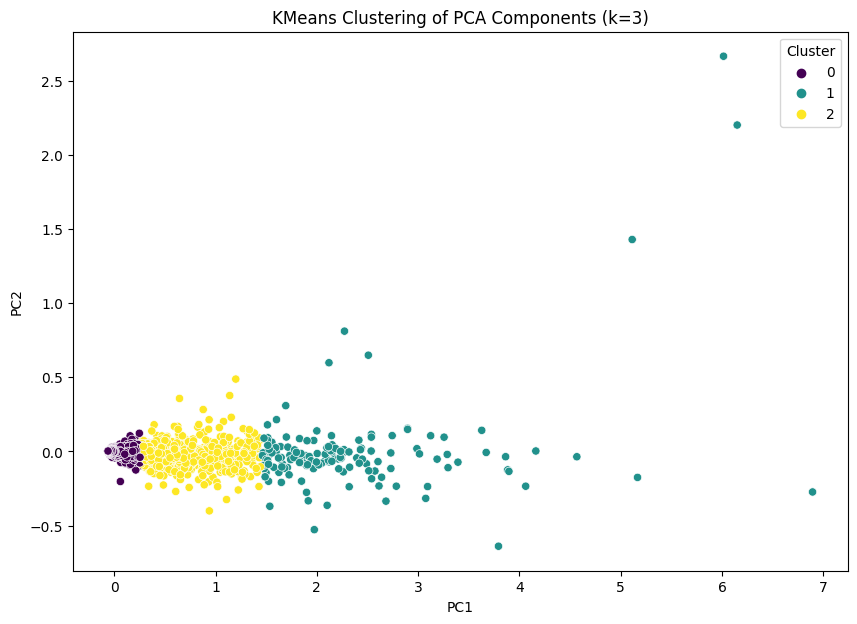

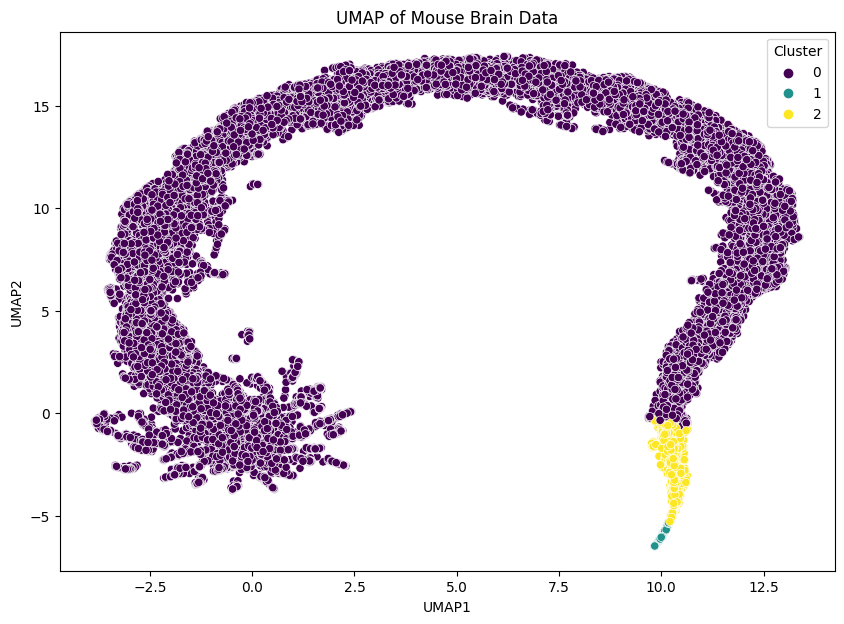

GO Enrichment for Cluster 0
  source      native                                               name  \
0     TF   TF:M04662       Factor: FOXN4; motif: NNWANNCGWMCGCGTCNNNNMT   
1  GO:BP  GO:0030154                               cell differentiation   
2  GO:BP  GO:0010604  positive regulation of macromolecule metabolic...   
3  GO:MF  GO:0036094                             small molecule binding   
4  GO:BP  GO:0051234                      establishment of localization   

         p_value  significant  \
0  4.940656e-324         True   
1  4.940656e-324         True   
2  4.940656e-324         True   
3  4.940656e-324         True   
4  4.940656e-324         True   

                                         description  term_size  query_size  \
0       Factor: FOXN4; motif: NNWANNCGWMCGCGTCNNNNMT      15957       14713   
1  "The cellular developmental process in which a...       4777       14322   
2  "Any process that increases the frequency, rat...       3427       14322   
3  "Bi

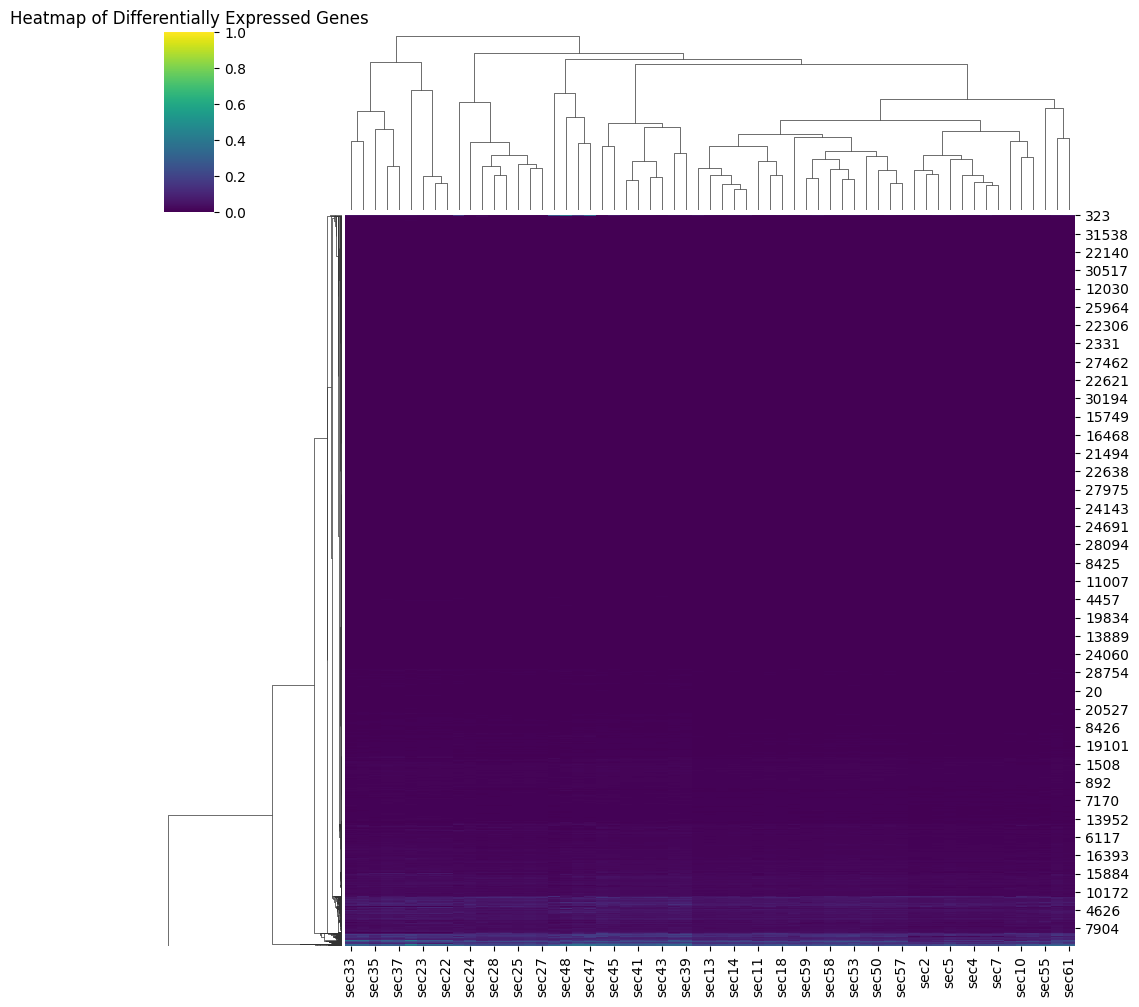

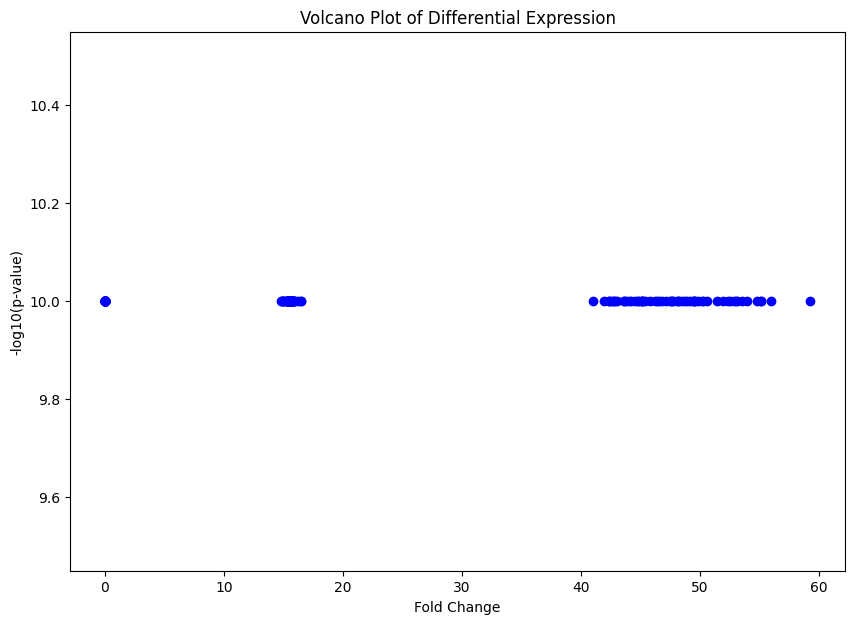

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap

# Step 1: Load the data
file_path = 'mousebrain.matrix'

try:
    data = pd.read_csv(file_path, delimiter='\t', header=0, dtype=str)
    data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
    print(data.head())
except Exception as e:
    print(f"An error occurred: {e}")

# Step 2: Basic Preprocessing
# Handling missing values (e.g., filling with mean of the column)
data.fillna(data.mean(numeric_only=True), inplace=True)

# Step 3: Normalization to mitigate the effect of outliers
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data.iloc[:, 1:])

# Step 4: PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_data)

# Creating a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['gene'] = data.iloc[:, 0]

# Plotting PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='gene', legend=None)
plt.title('PCA of Mouse Brain Data')
plt.show()

# Step 5: Elbow Method for Finding the Optimal Number of Clusters
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 7))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Step 6: Clustering using the Optimal Number of Clusters
optimal_k = 3  # Example value, choose based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
clusters = kmeans.fit_predict(normalized_data)

# Adding cluster information to the DataFrame
data['Cluster'] = clusters

# Plotting clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=data['Cluster'], palette='viridis')
plt.title(f'KMeans Clustering of PCA Components (k={optimal_k})')
plt.show()

# Step 7: UMAP for visualization
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1)
umap_components = umap_model.fit_transform(normalized_data)

# Creating a DataFrame with the UMAP components
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])
umap_df['Cluster'] = data['Cluster']

# Plotting UMAP
plt.figure(figsize=(10, 7))
sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df, hue='Cluster', palette='viridis')
plt.title('UMAP of Mouse Brain Data')
plt.show()

# Step 8: GO Enrichment Analysis
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)

# Perform GO enrichment analysis
for cluster in data['Cluster'].unique():
    cluster_genes = data[data['Cluster'] == cluster]['gene'].tolist()
    result = gp.profile(organism='mmusculus', query=cluster_genes)
    print(f"GO Enrichment for Cluster {cluster}")
    print(result.head())

# Step 9: Differential Expression Analysis
from scipy.stats import ttest_ind

# Convert data to numeric and drop non-numeric columns
numeric_data = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
numeric_data['Cluster'] = data['Cluster']

# Perform differential expression analysis
diff_exp_results = {}
for cluster in numeric_data['Cluster'].unique():
    for gene in numeric_data.columns[:-1]:
        cluster_data = numeric_data[numeric_data['Cluster'] == cluster][gene].dropna()
        other_data = numeric_data[numeric_data['Cluster'] != cluster][gene].dropna()
        t_stat, p_val = ttest_ind(cluster_data, other_data, equal_var=False)
        if p_val < 0.05:  # Assuming a significance threshold of 0.05
            if gene not in diff_exp_results:
                diff_exp_results[gene] = []
            diff_exp_results[gene].append((cluster, t_stat, p_val))

# Display differential expression results
for gene, results in diff_exp_results.items():
    print(f"Differentially expressed gene: {gene}")
    for result in results:
        print(f"Cluster: {result[0]}, t-stat: {result[1]}, p-value: {result[2]}")

# Step 10: Visualization of Differential Expression
# Heatmap of differentially expressed genes
import seaborn as sns

diff_exp_genes = list(diff_exp_results.keys())
heatmap_data = numeric_data[diff_exp_genes]
sns.clustermap(heatmap_data, standard_scale=1, cmap='viridis')
plt.title('Heatmap of Differentially Expressed Genes')
plt.show()

# Volcano Plot
import matplotlib.pyplot as plt
import numpy as np

fold_changes = []
log_p_values = []
for gene, results in diff_exp_results.items():
    for result in results:
        fold_change = np.mean(numeric_data[numeric_data['Cluster'] == result[0]][gene]) / np.mean(numeric_data[numeric_data['Cluster'] != result[0]][gene])
        fold_changes.append(fold_change)
        log_p_values.append(-np.log10(result[2] + 1e-10))  # Adding a small value to avoid log(0)

plt.figure(figsize=(10, 7))
plt.scatter(fold_changes, log_p_values, c='blue')
plt.xlabel('Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Differential Expression')
plt.show()


In [2]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)

# Perform pathway enrichment analysis
for cluster in data['Cluster'].unique():
    cluster_genes = data[data['Cluster'] == cluster]['gene'].tolist()
    result = gp.profile(organism='mmusculus', query=cluster_genes, sources=["KEGG", "REAC", "WP"])
    print(f"Pathway Enrichment for Cluster {cluster}")
    print(result.head())


Pathway Enrichment for Cluster 0
  source      native                        name       p_value  significant  \
0   KEGG  KEGG:05200          Pathways in cancer  6.034449e-33         True   
1   KEGG  KEGG:04010      MAPK signaling pathway  4.282935e-20         True   
2   KEGG  KEGG:04151  PI3K-Akt signaling pathway  6.812296e-19         True   
3   KEGG  KEGG:04360               Axon guidance  4.620314e-18         True   
4   KEGG  KEGG:01100          Metabolic pathways  1.573866e-17         True   

                  description  term_size  query_size  intersection_size  \
0          Pathways in cancer        543        6569                497   
1      MAPK signaling pathway        301        6569                279   
2  PI3K-Akt signaling pathway        364        6569                329   
3               Axon guidance        181        6569                175   
4          Metabolic pathways       1616        6569               1284   

   effective_domain_size  precision    re

C:\Users\ujami\AppData\Local\Temp\ipykernel_25420\578972471.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
C:\Users\ujami\AppData\Local\Temp\ipykernel_25420\578972471.py:11: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


Summary of Differential Expression Results:
Gene: sec1, Results: [(0, -36.02741786390797, 1.3740328737309183e-199), (2, 57.783726617593985, 0.0), (1, 22.924909597333638, 9.592194144531723e-50)]
Gene: sec2, Results: [(0, -34.86840578334922, 2.37894335898931e-190), (2, 61.06377362621122, 0.0), (1, 21.486128385936105, 1.2830109334835433e-46)]
Gene: sec3, Results: [(0, -35.909848224968904, 1.193818401209261e-198), (2, 62.77346561041452, 0.0), (1, 22.72161863090442, 2.6123007209295532e-49)]
Gene: sec4, Results: [(0, -36.22880564549295, 3.4156176297177824e-201), (2, 62.52786038560029, 0.0), (1, 22.993436030782537, 6.854316173221151e-50)]
Gene: sec5, Results: [(0, -36.811237754657355, 7.720495619923917e-206), (2, 62.41212465545067, 0.0), (1, 23.814325213331202, 1.2738806153809915e-51)]
Gene: sec6, Results: [(0, -35.70063839183889, 5.557264629372655e-197), (2, 61.486685015899425, 0.0), (1, 22.18120116942762, 3.836659761141959e-48)]
Gene: sec7, Results: [(0, -35.54626979919473, 9.46190705614280

Added edge: sec6 - sec17 (correlation: 0.9886844390954074)
Added edge: sec6 - sec18 (correlation: 0.982607712752515)
Added edge: sec6 - sec19 (correlation: 0.9814727601025506)
Added edge: sec6 - sec20 (correlation: 0.9085432441408774)
Added edge: sec6 - sec21 (correlation: 0.9108864994482616)
Added edge: sec6 - sec22 (correlation: 0.90925682000178)
Added edge: sec6 - sec23 (correlation: 0.9107694495563474)
Added edge: sec6 - sec24 (correlation: 0.9104370603635114)
Added edge: sec6 - sec25 (correlation: 0.9069801873869343)
Added edge: sec6 - sec27 (correlation: 0.9045781377676724)
Added edge: sec6 - sec32 (correlation: 0.9582075613705431)
Added edge: sec6 - sec33 (correlation: 0.9637045378409138)
Added edge: sec6 - sec34 (correlation: 0.9665255052055814)
Added edge: sec6 - sec35 (correlation: 0.9660500405410046)
Added edge: sec6 - sec36 (correlation: 0.9560046413368875)
Added edge: sec6 - sec37 (correlation: 0.958311219293111)
Added edge: sec6 - sec38 (correlation: 0.9716427162395648)
A

Added edge: sec11 - sec42 (correlation: 0.9802659525374339)
Added edge: sec11 - sec43 (correlation: 0.979470615449517)
Added edge: sec11 - sec44 (correlation: 0.9802634021737398)
Added edge: sec11 - sec45 (correlation: 0.976107434488013)
Added edge: sec11 - sec46 (correlation: 0.9559870946349153)
Added edge: sec11 - sec47 (correlation: 0.9314069334437766)
Added edge: sec11 - sec48 (correlation: 0.9159636631655387)
Added edge: sec11 - sec49 (correlation: 0.9837980313067267)
Added edge: sec11 - sec50 (correlation: 0.9855630154572578)
Added edge: sec11 - sec51 (correlation: 0.9825342950761164)
Added edge: sec11 - sec52 (correlation: 0.9773234329844714)
Added edge: sec11 - sec53 (correlation: 0.973137363717708)
Added edge: sec11 - sec54 (correlation: 0.9690742275075277)
Added edge: sec11 - sec55 (correlation: 0.9605741899591913)
Added edge: sec11 - sec56 (correlation: 0.9868066422660088)
Added edge: sec11 - sec57 (correlation: 0.9845466159087659)
Added edge: sec11 - sec58 (correlation: 0.9

Added edge: sec16 - sec45 (correlation: 0.9671035575050728)
Added edge: sec16 - sec46 (correlation: 0.9670444989406354)
Added edge: sec16 - sec47 (correlation: 0.9529072171447057)
Added edge: sec16 - sec48 (correlation: 0.938320487447494)
Added edge: sec16 - sec49 (correlation: 0.9691032921929972)
Added edge: sec16 - sec50 (correlation: 0.9788992825334589)
Added edge: sec16 - sec51 (correlation: 0.9852479968429648)
Added edge: sec16 - sec52 (correlation: 0.9875146439055567)
Added edge: sec16 - sec53 (correlation: 0.9863289737132144)
Added edge: sec16 - sec54 (correlation: 0.9799450787899461)
Added edge: sec16 - sec55 (correlation: 0.9473593795542776)
Added edge: sec16 - sec56 (correlation: 0.9781625158770442)
Added edge: sec16 - sec57 (correlation: 0.9847526561640291)
Added edge: sec16 - sec58 (correlation: 0.9855523891758334)
Added edge: sec16 - sec59 (correlation: 0.9874568520632178)
Added edge: sec16 - sec60 (correlation: 0.9900293792086498)
Added edge: sec16 - sec61 (correlation: 0

Added edge: sec21 - sec25 (correlation: 0.9420498648755896)
Added edge: sec21 - sec26 (correlation: 0.9398044831911472)
Added edge: sec21 - sec27 (correlation: 0.9445246690740643)
Added edge: sec21 - sec28 (correlation: 0.9283672071280281)
Added edge: sec21 - sec29 (correlation: 0.9236585987883063)
Added edge: sec21 - sec30 (correlation: 0.9207940676304348)
Added edge: sec21 - sec31 (correlation: 0.9351566793853376)
Added edge: sec21 - sec33 (correlation: 0.9282517591575237)
Added edge: sec21 - sec34 (correlation: 0.9548996580137286)
Added edge: sec21 - sec35 (correlation: 0.957806348348296)
Added edge: sec21 - sec36 (correlation: 0.9669247986061713)
Added edge: sec21 - sec37 (correlation: 0.9619720935821439)
Added edge: sec21 - sec38 (correlation: 0.9494801706093868)
Added edge: sec21 - sec39 (correlation: 0.9308473499748795)
Added edge: sec21 - sec40 (correlation: 0.9211509633751096)
Added edge: sec21 - sec41 (correlation: 0.9200315393578711)
Added edge: sec21 - sec42 (correlation: 0

Added edge: sec26 - sec19 (correlation: 0.9219324254896946)
Added edge: sec26 - sec20 (correlation: 0.9339985328678093)
Added edge: sec26 - sec21 (correlation: 0.9398044831911473)
Added edge: sec26 - sec22 (correlation: 0.9400560498941267)
Added edge: sec26 - sec23 (correlation: 0.9414444260093194)
Added edge: sec26 - sec24 (correlation: 0.9919420602108086)
Added edge: sec26 - sec25 (correlation: 0.9951758327773548)
Added edge: sec26 - sec27 (correlation: 0.997262323830891)
Added edge: sec26 - sec28 (correlation: 0.9926855122158859)
Added edge: sec26 - sec29 (correlation: 0.9923028237066804)
Added edge: sec26 - sec30 (correlation: 0.9920736834900902)
Added edge: sec26 - sec31 (correlation: 0.9666330362634096)
Added edge: sec26 - sec34 (correlation: 0.9104870917933799)
Added edge: sec26 - sec36 (correlation: 0.9118771632916925)
Added edge: sec26 - sec37 (correlation: 0.9053368618478953)
Added edge: sec26 - sec38 (correlation: 0.9476076788455271)
Added edge: sec26 - sec39 (correlation: 0

Added edge: sec31 - sec54 (correlation: 0.9449575991089595)
Added edge: sec31 - sec55 (correlation: 0.9125467978488261)
Added edge: sec31 - sec56 (correlation: 0.9238724191707338)
Added edge: sec31 - sec57 (correlation: 0.9224008519450931)
Added edge: sec31 - sec58 (correlation: 0.9385612224753618)
Added edge: sec31 - sec59 (correlation: 0.9242008213783663)
Added edge: sec31 - sec60 (correlation: 0.9280417477554809)
Added edge: sec31 - sec61 (correlation: 0.9350455884120241)
Added edge: sec31 - sec3 (correlation: 0.9021938140732549)
Added edge: sec31 - sec4 (correlation: 0.9036954765961666)
Added edge: sec31 - sec5 (correlation: 0.9107174585385737)
Added edge: sec31 - sec7 (correlation: 0.9042325042171143)
Added edge: sec31 - sec8 (correlation: 0.9042665502488707)
Added edge: sec31 - sec10 (correlation: 0.9085302931253547)
Added edge: sec31 - sec11 (correlation: 0.9054862877137931)
Added edge: sec31 - sec12 (correlation: 0.9161392650569526)
Added edge: sec31 - sec13 (correlation: 0.907

Added edge: sec36 - sec31 (correlation: 0.9089703418597993)
Added edge: sec36 - sec32 (correlation: 0.9264446882960258)
Added edge: sec36 - sec33 (correlation: 0.9649583706660083)
Added edge: sec36 - sec34 (correlation: 0.9871584479867596)
Added edge: sec36 - sec35 (correlation: 0.9950018272108292)
Added edge: sec36 - sec37 (correlation: 0.9957167101938016)
Added edge: sec36 - sec38 (correlation: 0.9796123811642982)
Added edge: sec36 - sec39 (correlation: 0.9604042816461786)
Added edge: sec36 - sec40 (correlation: 0.9546420898348578)
Added edge: sec36 - sec41 (correlation: 0.9534317615632367)
Added edge: sec36 - sec42 (correlation: 0.9506878219773744)
Added edge: sec36 - sec43 (correlation: 0.9427407032363605)
Added edge: sec36 - sec44 (correlation: 0.9364803014720436)
Added edge: sec36 - sec45 (correlation: 0.9402145180678347)
Added edge: sec36 - sec46 (correlation: 0.9488573222181941)
Added edge: sec36 - sec47 (correlation: 0.9436940745888341)
Added edge: sec36 - sec48 (correlation: 

Added edge: sec41 - sec17 (correlation: 0.9816492114561371)
Added edge: sec41 - sec18 (correlation: 0.9844445872534663)
Added edge: sec41 - sec19 (correlation: 0.9738254835111)
Added edge: sec41 - sec20 (correlation: 0.914438970837964)
Added edge: sec41 - sec21 (correlation: 0.920031539357871)
Added edge: sec41 - sec22 (correlation: 0.9181446176463873)
Added edge: sec41 - sec23 (correlation: 0.9197391434605894)
Added edge: sec41 - sec24 (correlation: 0.953921685889558)
Added edge: sec41 - sec25 (correlation: 0.9571734837526892)
Added edge: sec41 - sec26 (correlation: 0.9556693606421562)
Added edge: sec41 - sec27 (correlation: 0.9591140082128082)
Added edge: sec41 - sec28 (correlation: 0.9494714564123352)
Added edge: sec41 - sec29 (correlation: 0.9493282081081499)
Added edge: sec41 - sec30 (correlation: 0.9468646374336115)
Added edge: sec41 - sec31 (correlation: 0.9299147603125527)
Added edge: sec41 - sec32 (correlation: 0.9393107592386423)
Added edge: sec41 - sec33 (correlation: 0.9484

Added edge: sec46 - sec43 (correlation: 0.9760511929659759)
Added edge: sec46 - sec44 (correlation: 0.9728366202744211)
Added edge: sec46 - sec45 (correlation: 0.985791601981542)
Added edge: sec46 - sec47 (correlation: 0.9908457039557858)
Added edge: sec46 - sec48 (correlation: 0.9738199291088947)
Added edge: sec46 - sec49 (correlation: 0.9597091067153437)
Added edge: sec46 - sec50 (correlation: 0.9549550587855786)
Added edge: sec46 - sec51 (correlation: 0.9632433690656205)
Added edge: sec46 - sec52 (correlation: 0.9694365674251126)
Added edge: sec46 - sec53 (correlation: 0.9693239666275587)
Added edge: sec46 - sec54 (correlation: 0.9752824094015482)
Added edge: sec46 - sec55 (correlation: 0.947451051481594)
Added edge: sec46 - sec56 (correlation: 0.9618720159679766)
Added edge: sec46 - sec57 (correlation: 0.9641860142821616)
Added edge: sec46 - sec58 (correlation: 0.9718079638958249)
Added edge: sec46 - sec59 (correlation: 0.9653394712330575)
Added edge: sec46 - sec60 (correlation: 0.

Added edge: sec52 - sec3 (correlation: 0.9803163225722464)
Added edge: sec52 - sec4 (correlation: 0.9797811460497132)
Added edge: sec52 - sec5 (correlation: 0.9821920525906076)
Added edge: sec52 - sec6 (correlation: 0.976693258398249)
Added edge: sec52 - sec7 (correlation: 0.9758060088184982)
Added edge: sec52 - sec8 (correlation: 0.9763990822141395)
Added edge: sec52 - sec9 (correlation: 0.9702658672618767)
Added edge: sec52 - sec10 (correlation: 0.9630439960845287)
Added edge: sec52 - sec11 (correlation: 0.9773234329844714)
Added edge: sec52 - sec12 (correlation: 0.9829720626958852)
Added edge: sec52 - sec13 (correlation: 0.9844172198456763)
Added edge: sec52 - sec14 (correlation: 0.988519843901078)
Added edge: sec52 - sec15 (correlation: 0.9867982108200997)
Added edge: sec52 - sec16 (correlation: 0.9875146439055568)
Added edge: sec52 - sec17 (correlation: 0.9873215853984223)
Added edge: sec52 - sec18 (correlation: 0.9855384719124723)
Added edge: sec52 - sec19 (correlation: 0.9742467

Added edge: sec57 - sec51 (correlation: 0.9977320716390079)
Added edge: sec57 - sec52 (correlation: 0.9937875888556847)
Added edge: sec57 - sec53 (correlation: 0.9902800629201375)
Added edge: sec57 - sec54 (correlation: 0.9837877795616847)
Added edge: sec57 - sec55 (correlation: 0.9640644187453327)
Added edge: sec57 - sec56 (correlation: 0.9965197296474163)
Added edge: sec57 - sec58 (correlation: 0.9967530914216283)
Added edge: sec57 - sec59 (correlation: 0.9930435210088974)
Added edge: sec57 - sec60 (correlation: 0.9915941471025108)
Added edge: sec57 - sec61 (correlation: 0.9775656909077676)
Added edge: sec57 - sec1 (correlation: 0.9792879840738629)
Added edge: sec57 - sec2 (correlation: 0.9835731490062635)
Added edge: sec57 - sec3 (correlation: 0.9841357569299938)
Added edge: sec57 - sec4 (correlation: 0.9805287725603044)
Added edge: sec57 - sec5 (correlation: 0.9818863119974511)
Added edge: sec57 - sec6 (correlation: 0.9770266023647183)
Added edge: sec57 - sec7 (correlation: 0.97747

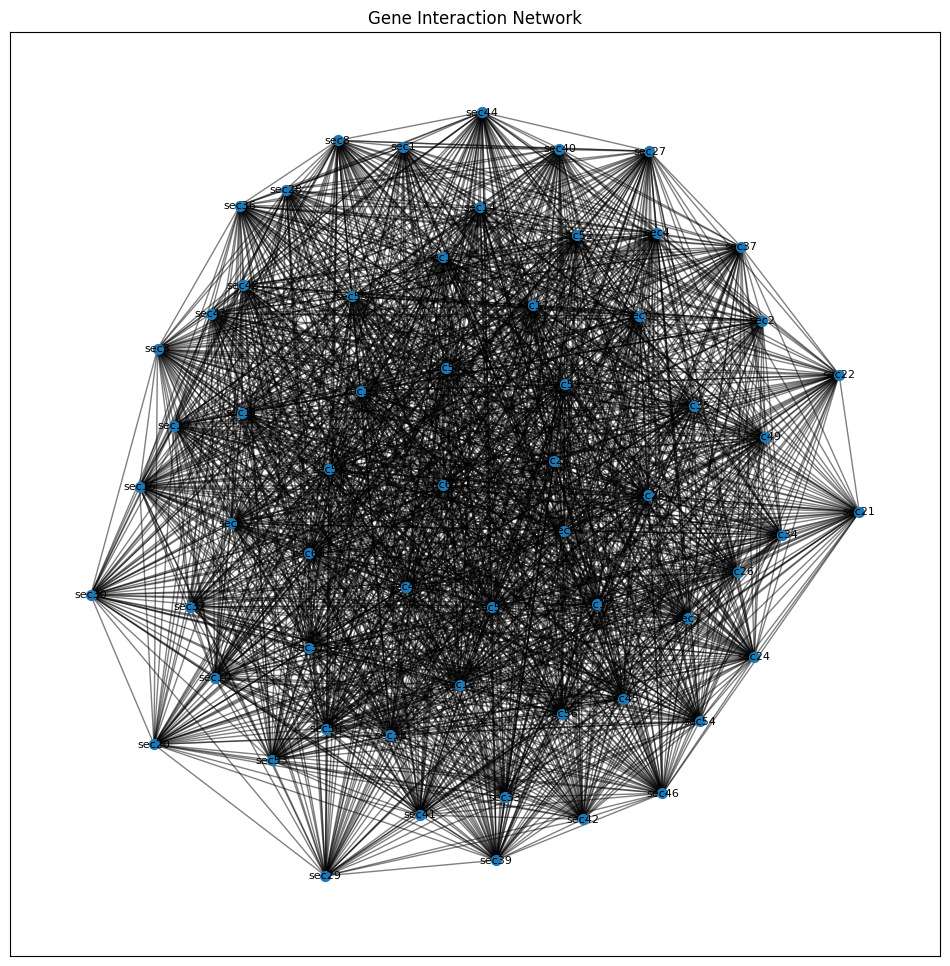

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Ensure all data is numeric
data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of each column
data.fillna(data.mean(), inplace=True)

# Perform differential expression analysis
diff_exp_results = {}
for cluster in data['Cluster'].unique():
    for gene in data.columns[1:-1]:  # Exclude the first column (genes) and the last column (Cluster)
        cluster_data = data[data['Cluster'] == cluster][gene]
        other_data = data[data['Cluster'] != cluster][gene]
        t_stat, p_val = ttest_ind(cluster_data, other_data, equal_var=False)
        if gene not in diff_exp_results:
            diff_exp_results[gene] = []
        diff_exp_results[gene].append((cluster, t_stat, p_val))

# Debugging: Print a summary of the differential expression results
print("Summary of Differential Expression Results:")
for gene, results in list(diff_exp_results.items())[:10]:  # Print a sample of the results
    print(f"Gene: {gene}, Results: {results}")

# Create a graph
G = nx.Graph()


threshold = 0.9

# Add nodes (genes) and edges (interactions)
for gene, results in diff_exp_results.items():
    if any(p_val < 0.05 for _, _, p_val in results):
        G.add_node(gene)
        for result in results:
            cluster, t_stat, p_val = result
            if p_val < 0.05:  # Only consider significant interactions
                for other_gene in data.columns[1:-1]:
                    if gene != other_gene:
                        correlation = np.corrcoef(data[gene], data[other_gene])[0, 1]
                        if correlation > threshold:
                            G.add_edge(gene, other_gene)
                            print(f"Added edge: {gene} - {other_gene} (correlation: {correlation})")

# Debugging: Print nodes and edges
print("Nodes in the network:", list(G.nodes())[:10])  # Print a sample of nodes
print("Edges in the network:", list(G.edges())[:10])  # Print a sample of edges

# Check if the network is empty
if len(G.nodes()) == 0:
    print("No significant interactions found. Please check the differential expression results and correlation threshold.")
else:
    # Visualize the network
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title('Gene Interaction Network')
    plt.show()


C:\Users\ujami\AppData\Local\Temp\ipykernel_25420\2263776142.py:11: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


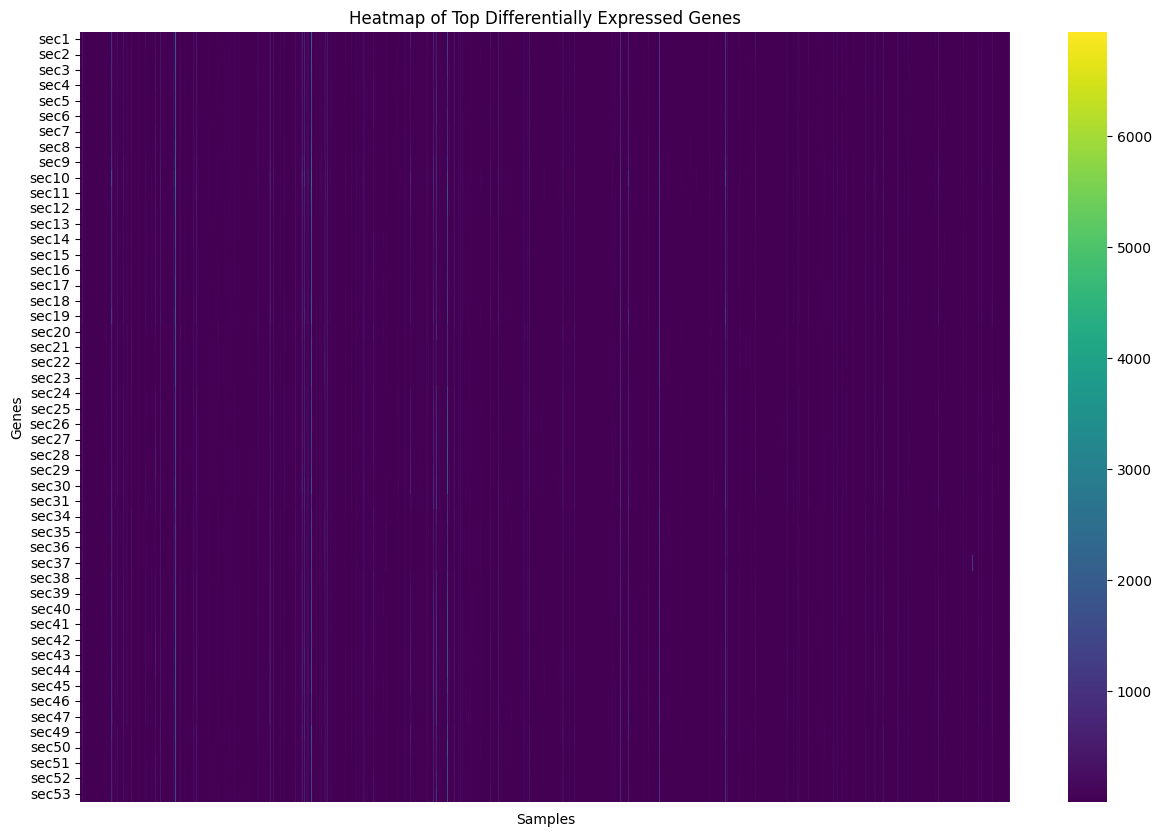

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Ensure all data is numeric
data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of each column
data.fillna(data.mean(), inplace=True)

# Perform differential expression analysis
diff_exp_results = {}
for cluster in data['Cluster'].unique():
    for gene in data.columns[1:-1]:  # Exclude the first column (genes) and the last column (Cluster)
        cluster_data = data[data['Cluster'] == cluster][gene]
        other_data = data[data['Cluster'] != cluster][gene]
        t_stat, p_val = ttest_ind(cluster_data, other_data, equal_var=False)
        if gene not in diff_exp_results:
            diff_exp_results[gene] = []
        diff_exp_results[gene].append((cluster, t_stat, p_val))

# Filter results for significant genes
significant_genes = {gene: results for gene, results in diff_exp_results.items() if any(p_val < 0.05 for _, _, p_val in results)}

# Select top differentially expressed genes
top_genes = sorted(significant_genes.keys(), key=lambda gene: min(result[2] for result in significant_genes[gene]))[:50]

# Create heatmap data
heatmap_data = data[top_genes].transpose()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, cmap='viridis', xticklabels=False)
plt.title('Heatmap of Top Differentially Expressed Genes')
plt.xlabel('Samples')
plt.ylabel('Genes')
plt.show()


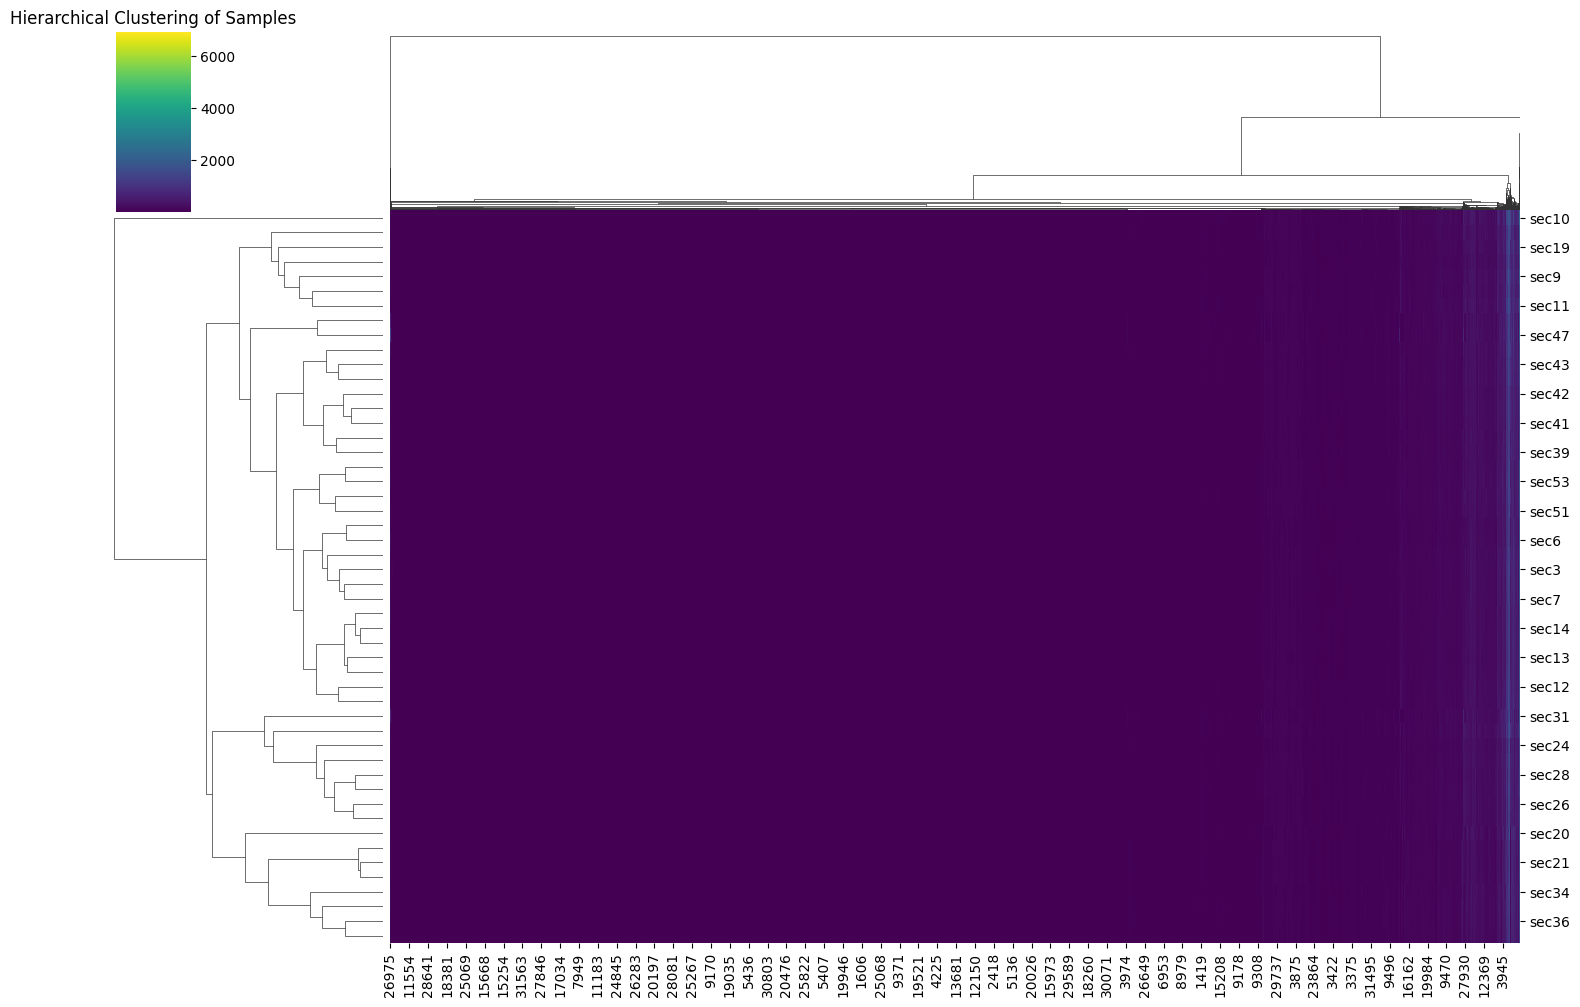

In [5]:
# Hierarchical clustering of samples
sns.clustermap(data[top_genes].transpose(), metric='euclidean', method='average', cmap='viridis', figsize=(15, 10))
plt.title('Hierarchical Clustering of Samples')
plt.show()


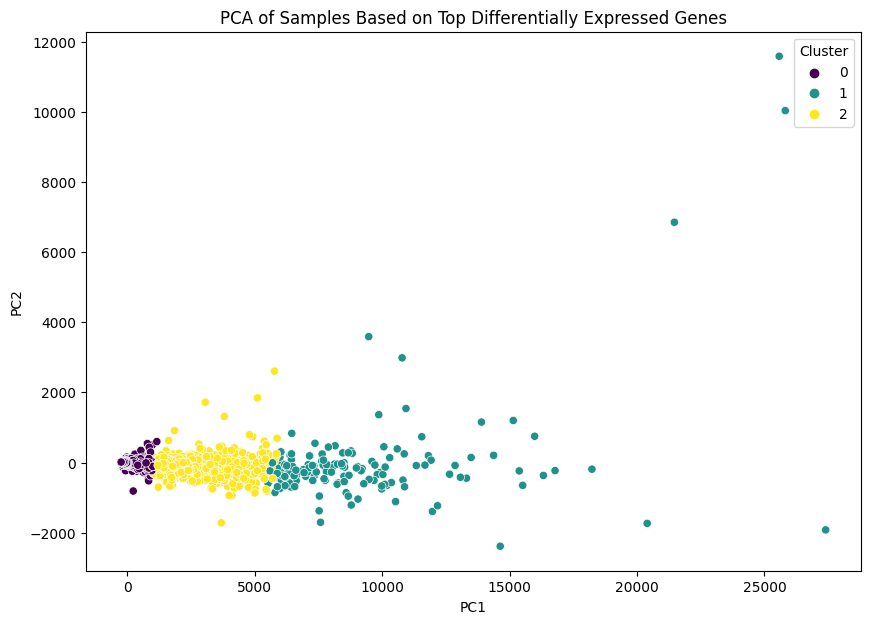

In [6]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[top_genes])
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = data['Cluster'].values

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('PCA of Samples Based on Top Differentially Expressed Genes')
plt.show()


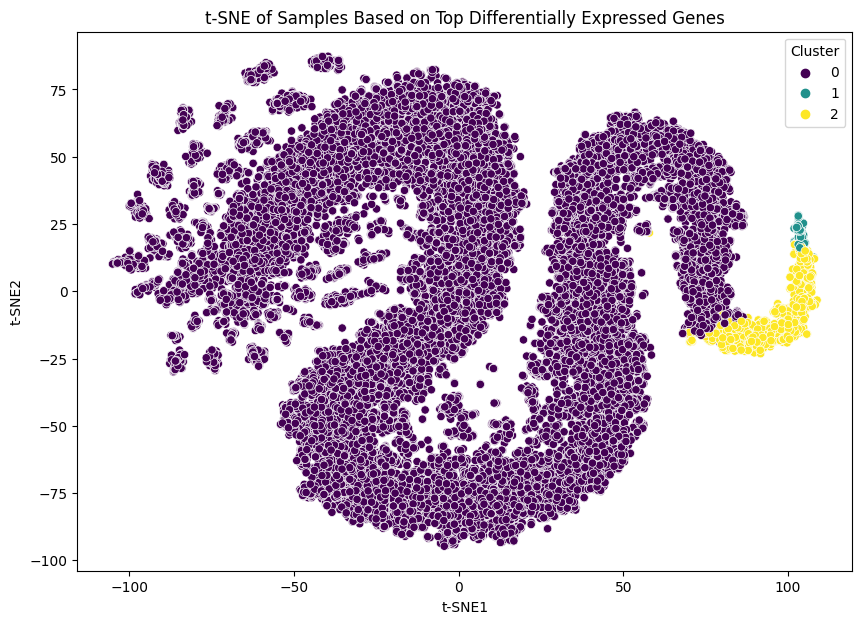

In [7]:
from sklearn.manifold import TSNE
# Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data[top_genes])
tsne_df = pd.DataFrame(tsne_result, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = data['Cluster'].values

plt.figure(figsize=(10, 7))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=tsne_df, palette='viridis')
plt.title('t-SNE of Samples Based on Top Differentially Expressed Genes')
plt.show()
